In [3]:
# #from SHEAP.fitting.functions import linear,GaussianSum,linear2,combine_auto
# from SHEAP.fitting.functions import GaussianSum
# from SHEAP.main_sheap import Sheapectral 
# from SHEAP.spectra_readers import parallel_reader 
# from SHEAP.complex_region.region import ComplexRegion
# from SHEAP.ploting import *
# from SHEAP.host_sub.start_method import Extract_host_star
# from SHEAP.tools.others import wl_to_kms
# from SHEAP.fe_handler import fe_template_read,galaxy_template_read
# from SHEAP.complex_region.building_region import RegionBuilder
# from SHEAP.complex_region.fit_fe import fe_template_read

In [1]:
from SHEAP.spectra_readers import parallel_reader 
from SHEAP.MainSheap import Sheapectral 
from SHEAP.RegionHandler.RegionBuilder import RegionBuilder
from SHEAP.RegionHandler.RegionFiting import RegionFiting
from SHEAP.ploting import *

In [2]:
import jax 
from jax import jit 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from paths_func import cross_pandas_spectra
jax.config.update("jax_enable_x64", True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path_dr16 = "/home/favila/smbh_mass/dr16"
#path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"

In [5]:
#dr16/subsample_07_03_25.csv

In [14]:
file_paths,objs_panda  = cross_pandas_spectra(path_dr16,"bernal_sdss_fits","Objects_low_stellar_mass_with_stellar_contribution.csv")
#file_paths,objs_panda = cross_pandas_spectra(path_dr16,"new_sub_sample_sdss_fits","subsample_07_03_25.csv")

You cross match found 413


In [7]:
#.iloc[0]

In [8]:
objs_panda.fit_path.iloc[0].split("/")[-1].replace(".fits","")

'2590-54175-0607'

In [16]:
coords,spectra_reshaped,_ = parallel_reader(objs_panda.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/favila/smbh_mass/SHEAP/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/SHEAP/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/SHEAP/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/SHEAP/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1]

In [10]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda["Z_DR16Q"].values,coords = coords)
z_s=test_clase.z
norm_factor=10**test_clase.spectra_exp
Spectra = test_clase.spectra

In [12]:
len(os.listdir("images"))

11422

In [18]:
for n in range(len(objs_panda)):
    name_file = os.path.join("images",objs_panda.fit_path.iloc[n].split("/")[-1].replace(".fits",".jpg"))
    if os.path.isfile(name_file):
        continue
    else:
        plot_a_spectra(Spectra[n],save=name_file)

/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/favila/smbh_mass/SHEAP/SHEAP/ploting.py:517: UserWarning: This figure

In [17]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda["Z"].values,coords = coords)
z_s=test_clase.z
norm_factor=10**test_clase.spectra_exp
Spectra = test_clase.spectra

In [114]:
region = RegionBuilder(4400, 5600)
region.make_region(verbose=True,Fe_regions=['Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"],force_linear=True,n_broad =2,narrow_plus=True) #,tied_to=[[["hydrogen","helium"],"center","Halpha_narrow"]])
Hbeta_class = RegionFiting(region.to_complex(add_free=True))

A region with limits 4400 to 5600 (A), 
with n_broad = 2 and n_narrow = 1 
and Fe regions ['Fe_uv', 'FeII_IZw1', 'feII_forbidden', 'FeII_coronal'], 
will be created
We assume a local linear continuum


In [115]:
#Hbeta_class = ComplexRegion("Hbeta")
Hbeta_class(Spectra,num_steps=100)

Runing: tied_params_step_1
learning_rate: 0.1
optimizer: adabelief
num_steps: 100
Runing: tied_params_step_2
We assume a local linear continuum
learning_rate: 0.01
optimizer: adabelief
num_steps: 200


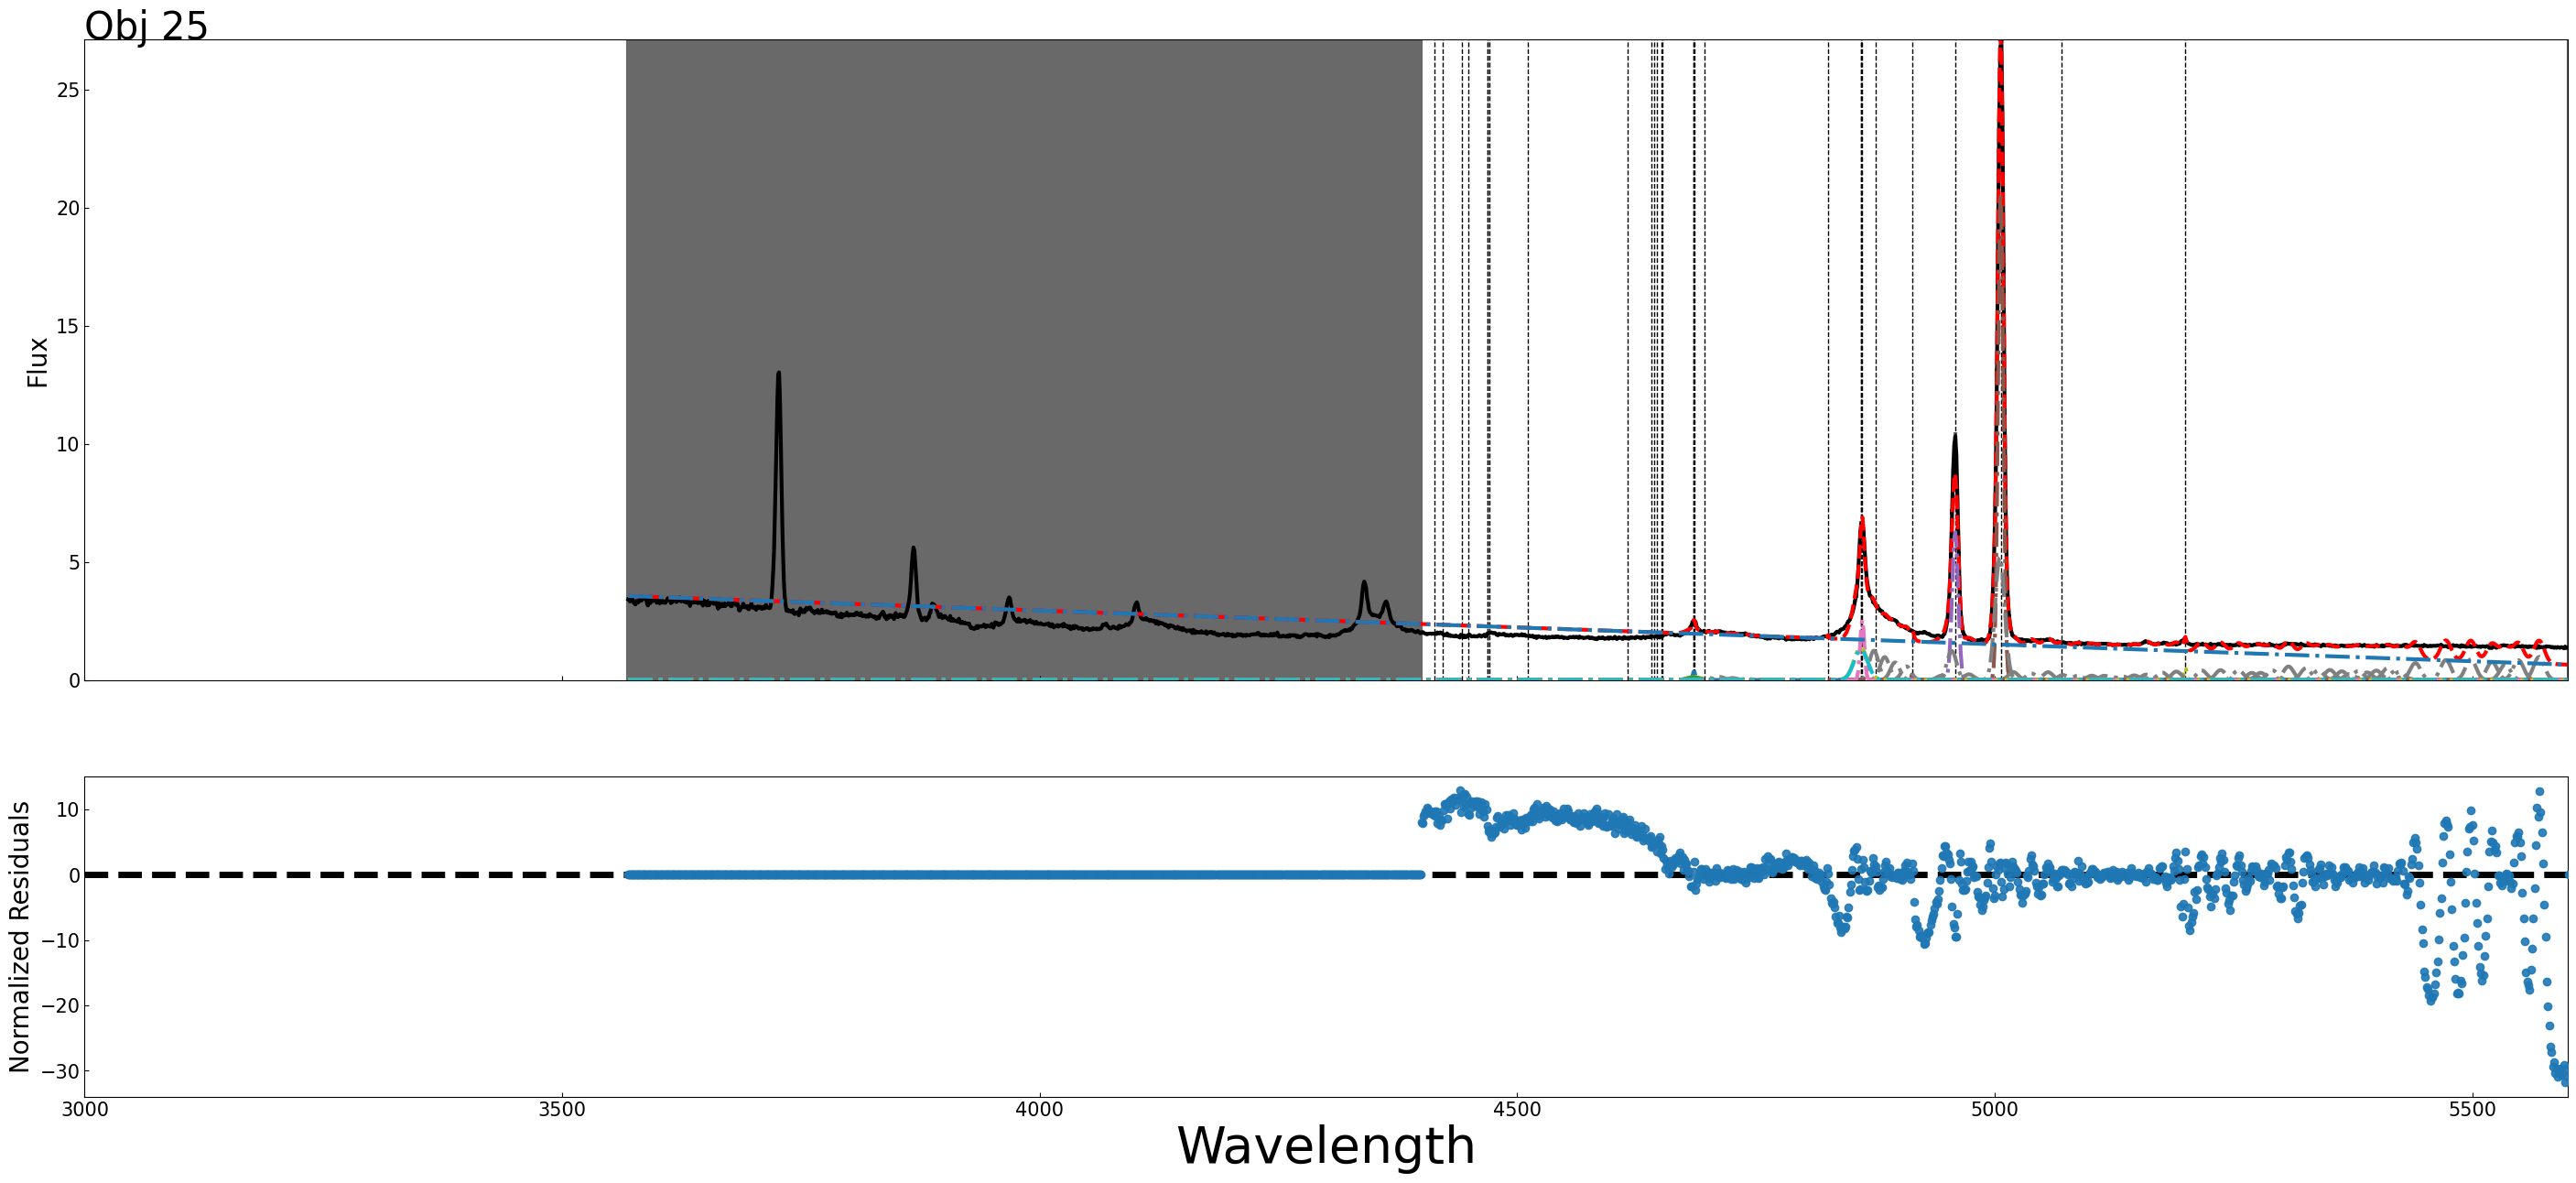

SDSS_NAME                                  spec-2603-54479-0259.fits
Z                                                            0.06739
stars_Cont_5100                                             0.611735
stars_Cont_6200                                             0.538896
PLATE                                                           2603
MJD                                                            54479
FIBERID                                                          259
dr_name                                              2603-54479-0259
fit_path           /home/favila/smbh_mass/dr16/bernal_sdss_fits/2...
Name: 25, dtype: object

In [118]:
n = 25
region_plot = SheapRegionplot(Hbeta_class)
region_plot.plot(n,xlim=[3000, 5600])#207
objs_panda.iloc[n]